In [1]:
!pip install altair

In [2]:
!pip install spacy

In [3]:
ls

sample_data/


In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import altair as alt
import pickle
import string
import spacy
import nltk
import re

from sklearn.naive_bayes import *
from sklearn.ensemble import *
from sklearn.neighbors import *
from sklearn.tree import *
from sklearn.calibration import *
from sklearn.linear_model import *
from sklearn.multiclass import *
from sklearn.svm import *
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from nltk.stem import WordNetLemmatizer
from collections import Counter

from spacy.lang.en.stop_words import STOP_WORDS
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, auc, roc_curve
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer, HashingVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.pipeline import Pipeline, make_pipeline

#nltk.download('stopwords')
sns.set(style='whitegrid')
%matplotlib inline
warnings.filterwarnings('ignore')

# Load data
df = pd.read_csv('sample_data/overview-of-recordings.csv')
df.head()

,audio_clipping,audio_clipping:confidence,background_noise_audible,background_noise_audible:confidence,overall_quality_of_the_audio,quiet_speaker,quiet_speaker:confidence,speaker_id,file_download,file_name,phrase,prompt,writer_id
0,no_clipping,1.0000,light_noise,1.0000,3.33,audible_speaker,1.0,43453425,https://ml.sandbox.cf3.us/cgi-bin/index.cgi?do...,1249120_43453425_58166571.wav,When I remember her I feel down,Emotional pain,21665495
1,light_clipping,0.6803,no_noise,0.6803,3.33,audible_speaker,1.0,43719934,https://ml.sandbox.cf3.us/cgi-bin/index.cgi?do...,1249120_43719934_43347848.wav,When I carry heavy things I feel like breaking...,Hair falling out,44088126
2,no_clipping,1.0000,no_noise,0.6655,3.33,audible_speaker,1.0,43719934,https://ml.sandbox.cf3.us/cgi-bin/index.cgi?do...,1249120_43719934_53187202.wav,there is too much pain when i move my arm,Heart hurts,44292353
3,no_clipping,1.0000,light_noise,1.0000,3.33,audible_speaker,1.0,31349958,https://ml.sandbox.cf3.us/cgi-bin/index.cgi?do...,1249120_31349958_55816195.wav,My son had his lip pierced and it is swollen a...,Infected wound,43755034
4,no_clipping,1.0000,no_noise,1.0000,4.67,audible_speaker,1.0,43719934,https://ml.sandbox.cf3.us/cgi-bin/index.cgi?do...,1249120_43719934_82524191.wav,My muscles in my lower back are aching,Infected wound,21665495


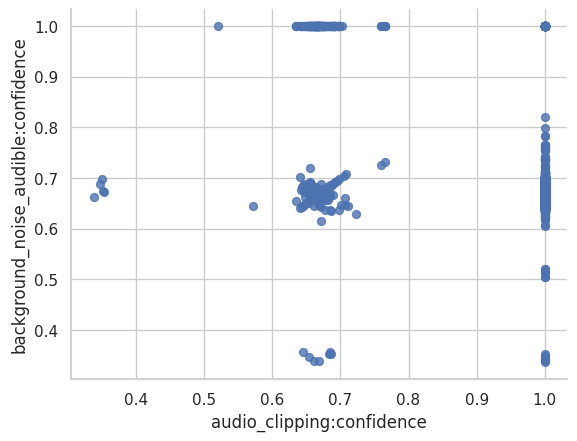

In [5]:
from matplotlib import pyplot as plt
df.plot(kind='scatter', x='audio_clipping:confidence', y='background_noise_audible:confidence', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

# [**Exploratory Data Analysis**](http://)

In [6]:
#Analyze Data
def explore_data(df):
    print(f"The data contains {df.shape[0]} rows and {df.shape[1]} columns.")
    print('\n')
    print('Dataset columns:',df.columns)
    print('\n')
    print(df.info())

explore_data(df)

The data contains 6661 rows and 13 columns.


Dataset columns: Index(['audio_clipping', 'audio_clipping:confidence',
       'background_noise_audible', 'background_noise_audible:confidence',
       'overall_quality_of_the_audio', 'quiet_speaker',
       'quiet_speaker:confidence', 'speaker_id', 'file_download', 'file_name',
       'phrase', 'prompt', 'writer_id'],
      dtype='object')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6661 entries, 0 to 6660
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   audio_clipping                       6661 non-null   object 
 1   audio_clipping:confidence            6661 non-null   float64
 2   background_noise_audible             6661 non-null   object 
 3   background_noise_audible:confidence  6661 non-null   float64
 4   overall_quality_of_the_audio         6661 non-null   float64
 5   quiet_speaker                      

# [**Checking for Nan Values and duplicates**¶](http://)

In [7]:
df.isna().sum()

,0
audio_clipping,0
audio_clipping:confidence,0
background_noise_audible,0
background_noise_audible:confidence,0
overall_quality_of_the_audio,0
quiet_speaker,0
quiet_speaker:confidence,0
speaker_id,0
file_download,0
file_name,0


In [8]:
def checking_removing_duplicates(df):
    count_dups = df.duplicated().sum()
    print("Number of Duplicates: ", count_dups)
    if count_dups >= 1:
        df.drop_duplicates(inplace=True)
        print('Duplicate values removed!')
    else:
        print('No Duplicate values')
checking_removing_duplicates(df)

Number of Duplicates:  0
No Duplicate values


# **Corpus**

In [9]:
df_text = df[['phrase', 'prompt']]
df_text

,phrase,prompt
0,When I remember her I feel down,Emotional pain
1,When I carry heavy things I feel like breaking...,Hair falling out
2,there is too much pain when i move my arm,Heart hurts
3,My son had his lip pierced and it is swollen a...,Infected wound
4,My muscles in my lower back are aching,Infected wound
...,...,...
6656,I feel a burning sensation in my guts about 2 ...,Stomach ache
6657,I have a split on my thumb that will not heal.,Open wound
6658,I feel a lot of pain in the joints.,Joint pain
6659,The area around my heart doesn't feel good.,Heart hurts


# **Document-Term Matrix**

In [11]:
cv = CountVectorizer()
df_cv = cv.fit_transform(df_text.phrase)
data_dtm = pd.DataFrame(df_cv.toarray(), columns=cv.get_feature_names_out()) # Use get_feature_names_out() instead of get_feature_names()
data_dtm.index = df_text.index
data_dtm


,10,100,15,500m,70,abdomen,abdominal,able,about,above,...,yard,year,years,yellow,yesterday,you,young,your,zits,ït
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6656,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
6657,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6658,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6659,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
# Add features
# Number of characters in the text
df_text['phrase_length'] = df_text['phrase'].apply(len)
# Number of words in the text
df_text['phrase_num_words'] = df_text['phrase'].apply(lambda x: len(x.split()))
# Average length of the words in the text
df_text["mean_word_len"] = df_text["phrase"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
# Number of non-stopwords in the text
df_text['phrase_non_stopwords'] = df_text['phrase'].apply(lambda x: len([t for t in x.split() if t not in STOP_WORDS]))
df_text.describe().T

,count,mean,std,min,25%,50%,75%,max
phrase_length,6661.0,50.026122,23.672184,9.000000,33.000000,45.0,61.000000,155.000000
phrase_num_words,6661.0,10.543462,4.807787,2.000000,7.000000,10.0,13.000000,30.000000
mean_word_len,6661.0,3.869025,0.663366,2.428571,3.461538,3.8,4.166667,7.666667
phrase_non_stopwords,6661.0,6.056598,2.574583,1.000000,4.000000,6.0,7.000000,17.000000


In [ ]:
cat_dist = df_text['prompt'].value_counts().reset_index().rename(columns={'index':'Label', 'prompt':'Count'})
cat_dist.drop(0, axis=0, inplace=True)
alt.Chart(cat_dist).mark_bar(opacity=0.7).encode(
    x=alt.X('Count', title='Count'),
    y=alt.Y('Label', sort='-x',title='Category'),
    tooltip=['Label','Count']
).properties(height=800,width=700,title="Class Distribution")

In [23]:
target = df_text['prompt'].values
counter = Counter(target)
for k,v in counter.items():
    per = v / len(target) * 100
    print('Class=%s, Count=%d, Percentage=%.3f%%' % (k, v, per))

Class=Emotional pain, Count=231, Percentage=3.468%
Class=Hair falling out, Count=264, Percentage=3.963%
Class=Heart hurts, Count=273, Percentage=4.098%
Class=Infected wound, Count=306, Percentage=4.594%
Class=Foot ache, Count=223, Percentage=3.348%
Class=Shoulder pain, Count=320, Percentage=4.804%
Class=Injury from sports, Count=230, Percentage=3.453%
Class=Skin issue, Count=262, Percentage=3.933%
Class=Stomach ache, Count=261, Percentage=3.918%
Class=Knee pain, Count=305, Percentage=4.579%
Class=Joint pain, Count=318, Percentage=4.774%
Class=Hard to breath, Count=233, Percentage=3.498%
Class=Head ache, Count=263, Percentage=3.948%
Class=Body feels weak, Count=241, Percentage=3.618%
Class=Feeling dizzy, Count=283, Percentage=4.249%
Class=Back pain, Count=259, Percentage=3.888%
Class=Open wound, Count=208, Percentage=3.123%
Class=Internal pain, Count=248, Percentage=3.723%
Class=Blurry vision, Count=246, Percentage=3.693%
Class=Acne, Count=328, Percentage=4.924%
Class=Muscle pain, Count

In [26]:
alt.data_transformers.disable_max_rows()
alt.Chart(df_text).mark_bar(color="violet",opacity=0.7,
    interpolate='step').encode(
    alt.X("phrase_length:Q",  bin=alt.Bin(maxbins=100), title='Phrase Length Class'),
    alt.Y('count()', axis=alt.Axis(labels=False), title='Frequency'),
    tooltip=['phrase_length']
).properties(
    height=400,
    width=700, title="Length Distribution")

alt.Chart(...)

In [27]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [28]:
nltk.download('averaged_perceptron_tagger')


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [29]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [30]:
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [31]:
def clean_txt(docs):
    lemmatizer = WordNetLemmatizer()
    # split into words
    speech_words = nltk.word_tokenize(docs)
    # convert to lower case
    lower_text = [w.lower() for w in speech_words]
    # prepare regex for char filtering
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    # remove punctuation from each word
    stripped = [re_punc.sub('', w) for w in lower_text]
    # remove remaining tokens that are not alphabetic
    words = [word for word in stripped if word.isalpha()]
    # filter out stop words
    words = [w for w in words if not w in  list(STOP_WORDS)]
    # filter out short tokens
    words = [word for word in words if len(word) > 2]
    #Stemm all the words in the sentence
    lem_words = [lemmatizer.lemmatize(word) for word in words]
    combined_text = ' '.join(lem_words)
    return combined_text

# Cleaning the text data
df_text['cleaned_phrase'] = df_text['phrase'].apply(clean_txt)
df_text

,phrase,prompt,phrase_length,phrase_num_words,mean_word_len,phrase_non_stopwords,cleaned_phrase
0,When I remember her I feel down,Emotional pain,31,7,3.571429,5,remember feel
1,When I carry heavy things I feel like breaking...,Hair falling out,54,11,4.000000,9,carry heavy thing feel like breaking
2,there is too much pain when i move my arm,Heart hurts,41,10,3.200000,2,pain arm
3,My son had his lip pierced and it is swollen a...,Infected wound,103,22,3.727273,11,son lip pierced swollen skin inside lip grey l...
4,My muscles in my lower back are aching,Infected wound,38,8,3.875000,4,muscle lower aching
...,...,...,...,...,...,...,...
6656,I feel a burning sensation in my guts about 2 ...,Stomach ache,68,14,3.928571,8,feel burning sensation gut hour meal
6657,I have a split on my thumb that will not heal.,Open wound,46,11,3.272727,4,split thumb heal
6658,I feel a lot of pain in the joints.,Joint pain,35,9,3.000000,5,feel lot pain joint
6659,The area around my heart doesn't feel good.,Heart hurts,43,8,4.500000,6,area heart feel good


In [32]:
from google.colab import sheets
sheet = sheets.InteractiveSheet(df=df_text)

https://docs.google.com/spreadsheets/d/1X4hzXBUoOdwU1f6qRDiSwlAeuEVzXC5FAajep8Um938#gid=0


In [33]:
from nltk.probability import FreqDist

In [34]:
freq_splits = FreqDist(df_text['phrase'])
print(f"***** 10 most common strings ***** \n{freq_splits.most_common(10)}", "\n")

***** 10 most common strings ***** 
[('When I stand up too quickly I start to feel dizzy and light-headed', 35), ('There is a sharp pain in my bicep. I have tried to apply pain relief cream but it does not help.', 18), ('I feel like the room is spinning', 15), ('I feel a pain in my back', 12), ("My back hurts me and i can't bend it or walk", 12), ("I can't do anything I feel a weak in my body", 12), ('My skin is very dry and peeling.', 12), ('There is pain in the muscles I do not know caused', 12), ('My knee hurts when I play squash', 12), ('I feel pain in my shoulders when I write on the keyboard.', 12)] 



#Text Data Preparation and Model Training


In [35]:
# Spot-Check Normalized Text Models
def NormalizedTextModel(nameOfvect):
    if nameOfvect == 'countvect':
        vectorizer = CountVectorizer()
    elif nameOfvect =='tfvect':
        vectorizer = TfidfVectorizer()
    elif nameOfvect == 'hashvect':
        vectorizer = HashingVectorizer()

    pipelines = []
    pipelines.append((nameOfvect+'MultinomialNB'  , Pipeline([('Vectorizer', vectorizer),('NB'  , MultinomialNB())])))
    pipelines.append((nameOfvect+'CCCV' , Pipeline([('Vectorizer', vectorizer),('CCCV' , CalibratedClassifierCV())])))
    pipelines.append((nameOfvect+'KNN' , Pipeline([('Vectorizer', vectorizer),('KNN' , KNeighborsClassifier())])))
    pipelines.append((nameOfvect+'CART', Pipeline([('Vectorizer', vectorizer),('CART', DecisionTreeClassifier())])))
    pipelines.append((nameOfvect+'PAC'  , Pipeline([('Vectorizer', vectorizer),('PAC'  , PassiveAggressiveClassifier())])))
    pipelines.append((nameOfvect+'SVM' , Pipeline([('Vectorizer', vectorizer),('RC' , RidgeClassifier())])))
    pipelines.append((nameOfvect+'AB'  , Pipeline([('Vectorizer', vectorizer),('AB'  , AdaBoostClassifier())])  ))
    pipelines.append((nameOfvect+'GBM' , Pipeline([('Vectorizer', vectorizer),('GMB' , GradientBoostingClassifier())])))
    pipelines.append((nameOfvect+'RF'  , Pipeline([('Vectorizer', vectorizer),('RF'  , RandomForestClassifier())])))
    pipelines.append((nameOfvect+'ET'  , Pipeline([('Vectorizer', vectorizer),('ET'  , ExtraTreesClassifier())])))
    pipelines.append((nameOfvect+'SGD'  , Pipeline([('Vectorizer', vectorizer),('SGD'  , SGDClassifier())])))
    pipelines.append((nameOfvect+'OVRC'  , Pipeline([('Vectorizer', vectorizer),('OVRC'  , OneVsRestClassifier(LogisticRegression()))])))
    pipelines.append((nameOfvect+'Bagging'  , Pipeline([('Vectorizer', vectorizer),('Bagging'  , BaggingClassifier())])))
    pipelines.append((nameOfvect+'NN'  , Pipeline([('Vectorizer', vectorizer),('NN'  , MLPClassifier())])))
    #pipelines.append((nameOfvect+'xgboost', Pipeline([('Vectorizer', vectorizer), ('xgboost', XGBClassifier())])))
    return pipelines

# Traing model
def fit_model(X_train, y_train,models):
    # Test options and evaluation metric
    num_folds = 10
    scoring = 'accuracy'

    results = []
    names = []
    for name, model in models:
        kfold = KFold(n_splits=num_folds)
        cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)

# Split data to training and validation set
def read_in_and_split_data(data, features,target):
    X = data[features]
    y = data[target]
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=0)
    return X_train, X_test, y_train, y_test

X = 'cleaned_phrase'
target_class = 'prompt'
X_train, X_test, y_train, y_test = read_in_and_split_data(df_text, X, target_class)

#Bag of Words Model


## [Word Counts with countvectorizer ]


In [36]:
# sample text
sample_text_count = X_train[:10]
# create the transform
vectorizer = CountVectorizer()
# tokenize and build vocab
vectorizer.fit(sample_text_count)
# summarize
print(vectorizer.vocabulary_)
# encode document
vector = vectorizer.transform(sample_text_count)
# summarize encoded vector
print(vector.shape)
print(type(vector))
print(vector.toarray())

{'pimple': 21, 'skin': 25, 'disease': 3, 'pain': 20, 'fell': 7, 'floor': 8, 'radiates': 22, 'chest': 2, 'left': 12, 'arm': 1, 'turn': 27, 'neck': 16, 'feeling': 6, 'stabbing': 26, 'like': 14, 'needle': 17, 'joint': 10, 'feel': 5, 'shoulder': 24, 'lightning': 13, 'sent': 23, 'noticed': 18, 'hair': 9, 'falling': 4, 'lot': 15, 'lately': 11, 'acne': 0, 'year': 29, 'old': 19, 'weak': 28}
(10, 30)
<class 'scipy.sparse._csr.csr_matrix'>
[[0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 1 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 2 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 1 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1]

# [**Spot-Check Algorithms with Countvectorizer**](http://)

In [37]:
# Contvectorizer
models = NormalizedTextModel('countvect')
fit_model(X_train, y_train, models)

countvectMultinomialNB: 0.955143 (0.007142)
countvectCCCV: 0.993994 (0.003638)
countvectKNN: 0.993057 (0.003564)
countvectCART: 0.996621 (0.002189)
countvectPAC: 0.992306 (0.003188)
countvectSVM: 0.990430 (0.004629)
countvectAB: 0.348731 (0.034927)
countvectGBM: 0.993245 (0.004041)
countvectRF: 0.996621 (0.002189)
countvectET: 0.996621 (0.002189)
countvectSGD: 0.991742 (0.004296)
countvectOVRC: 0.988364 (0.004005)
countvectBagging: 0.997373 (0.001913)
countvectNN: 0.997373 (0.001913)


## [**Word Frequencies with TfidfVectorizer** ]


In [38]:
# sample text
sample_text_Tfid = X_train[:10]
# create the transform
vectorizer = TfidfVectorizer()
# tokenize and build vocab
vectorizer.fit(sample_text_Tfid)
# summarize
print(vectorizer.vocabulary_)
print(vectorizer.idf_)
# encode document
vector = vectorizer.transform(sample_text_Tfid)
# summarize encoded vector
print(vector.shape)
print(vector.toarray())

{'pimple': 21, 'skin': 25, 'disease': 3, 'pain': 20, 'fell': 7, 'floor': 8, 'radiates': 22, 'chest': 2, 'left': 12, 'arm': 1, 'turn': 27, 'neck': 16, 'feeling': 6, 'stabbing': 26, 'like': 14, 'needle': 17, 'joint': 10, 'feel': 5, 'shoulder': 24, 'lightning': 13, 'sent': 23, 'noticed': 18, 'hair': 9, 'falling': 4, 'lot': 15, 'lately': 11, 'acne': 0, 'year': 29, 'old': 19, 'weak': 28}
[2.70474809 2.70474809 2.70474809 2.70474809 2.70474809 2.29928298
 2.70474809 2.70474809 2.70474809 2.70474809 2.70474809 2.70474809
 2.29928298 2.70474809 2.29928298 2.70474809 2.70474809 2.70474809
 2.70474809 2.70474809 1.6061358  2.70474809 2.70474809 2.70474809
 2.70474809 2.70474809 2.70474809 2.70474809 2.70474809 2.70474809]
(10, 30)
[[0.         0.         0.         0.57735027 0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.57735027 0.         0.
  0.         0.57735027 0.   

# [**Spot-Check Algorithms with TfidfVectorizer**](http://)

In [39]:
# TfidfVectorizer
models = NormalizedTextModel('tfvect')
fit_model(X_train, y_train, models)

tfvectMultinomialNB: 0.968281 (0.006077)
tfvectCCCV: 0.991554 (0.003957)
tfvectKNN: 0.987800 (0.004767)
tfvectCART: 0.996434 (0.002441)
tfvectPAC: 0.992495 (0.004110)
tfvectSVM: 0.990615 (0.003658)
tfvectAB: 0.408951 (0.048058)
tfvectGBM: 0.995120 (0.002253)
tfvectRF: 0.996621 (0.002189)
tfvectET: 0.996621 (0.002189)
tfvectSGD: 0.990991 (0.003118)
tfvectOVRC: 0.985548 (0.005995)
tfvectBagging: 0.997373 (0.001913)
tfvectNN: 0.996997 (0.002090)


## [Hashing with HashingVectorize]

In [40]:
# sample text
sample_text_hash = X_train[:10]
# create the transform
vectorizer = HashingVectorizer(n_features=20)
# encode document
vector = vectorizer.transform(sample_text_hash)
# summarize encoded vector
print(vector.shape)
print(vector.toarray())

(10, 20)
[[ 0.         -0.57735027  0.          0.          0.          0.
   0.          0.          0.57735027  0.          0.          0.
  -0.57735027  0.          0.          0.          0.          0.
   0.          0.        ]
 [ 0.57735027  0.          0.          0.          0.          0.
   0.          0.         -0.57735027  0.          0.57735027  0.
   0.          0.          0.          0.          0.          0.
   0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.         -0.75592895  0.37796447 -0.37796447  0.
   0.          0.          0.37796447  0.          0.          0.
   0.          0.        ]
 [ 0.          0.          0.          0.         -0.35355339  0.
   0.35355339  0.         -0.70710678  0.          0.          0.
   0.         -0.35355339  0.         -0.35355339  0.          0.
   0.          0.        ]
 [ 0.          0.5         0.          0.          0.          0.
   0.         -0.5       

# [**Spot-Check Algorithms  with HashingVectorizer**](http://)

# [**Fine tuning**](http://)

In [41]:
vectorizer = TfidfVectorizer()
X_train_1 = vectorizer.fit_transform(X_train)
model = BaggingClassifier()
n_estimators = [10, 100, 1000]
#learning_rate= [0.1, 0.001, 0.0001]
#max_depth = [4,5,6]
#min_child_weight=[4,5,6]

#define grid search
grid = dict(n_estimators=n_estimators)
cv = KFold(n_splits=10)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy')
grid_result = grid_search.fit(X_train_1, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.996621 using {'n_estimators': 10}
0.996621 (0.002189) with: {'n_estimators': 10}
0.996621 (0.002189) with: {'n_estimators': 100}
0.996621 (0.002189) with: {'n_estimators': 1000}


# [**Predict unseen data**](http://)

Training Accuracy Score: 99.8%
Validation Accuracy Score: 99.5%


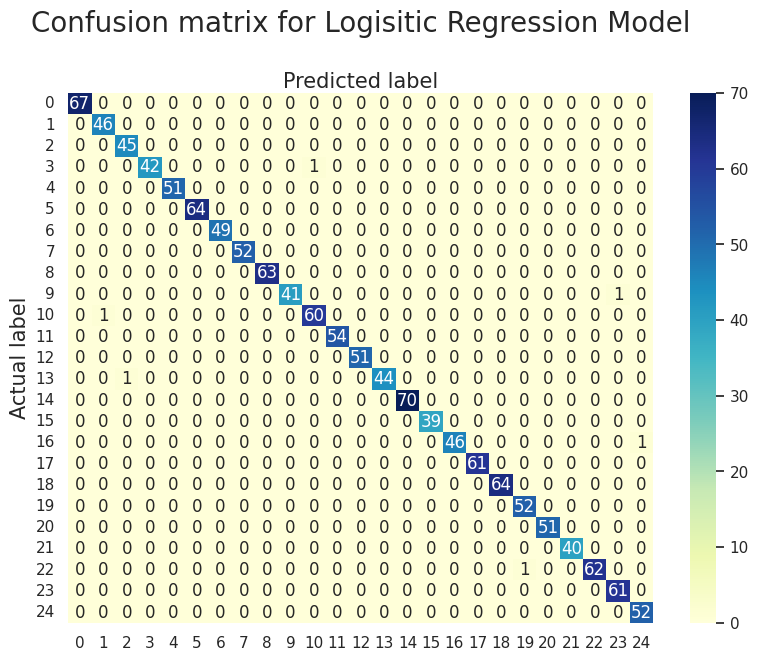

                    precision    recall  f1-score   support

              Acne       1.00      1.00      1.00        67
         Back pain       0.98      1.00      0.99        46
     Blurry vision       0.98      1.00      0.99        45
   Body feels weak       1.00      0.98      0.99        43
             Cough       1.00      1.00      1.00        51
          Ear ache       1.00      1.00      1.00        64
    Emotional pain       1.00      1.00      1.00        49
      Feeling cold       1.00      1.00      1.00        52
     Feeling dizzy       1.00      1.00      1.00        63
         Foot ache       1.00      0.98      0.99        42
  Hair falling out       0.98      0.98      0.98        61
    Hard to breath       1.00      1.00      1.00        54
         Head ache       1.00      1.00      1.00        51
       Heart hurts       1.00      0.98      0.99        45
    Infected wound       1.00      1.00      1.00        70
Injury from sports       1.00      1.00

In [42]:
def classification_metrics(model, y_test, y_pred):
    print(f"Training Accuracy Score: {model.score(X_train, y_train) * 100:.1f}%")
    print(f"Validation Accuracy Score: {model.score(X_test, y_test) * 100:.1f}%")

    conf_matrix = confusion_matrix(y_test, y_pred)
    fig,ax = plt.subplots(figsize=(8,6))
    sns.heatmap(pd.DataFrame(conf_matrix), annot = True, cmap = 'YlGnBu',fmt = 'g')
    ax.xaxis.set_label_position('top')
    plt.tight_layout()
    plt.title('Confusion matrix for Logisitic Regression Model', fontsize=20, y=1.1)
    plt.ylabel('Actual label', fontsize=15)
    plt.xlabel('Predicted label', fontsize=15)
    plt.show()
    print(classification_report(y_test, y_pred))

text_clf = Pipeline([('vect', TfidfVectorizer()),('bagging', BaggingClassifier(n_estimators=10))])
model = text_clf.fit(X_train, y_train)
y_pred = model.predict(X_test)
classification_metrics(model,y_test, y_pred)

In [47]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier  # Simple deep learning (multi-layer perceptron)
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

# Function to fit and evaluate models
def fit_model(X_train, y_train, models):
    num_folds = 10
    scoring = 'accuracy'

    results = []
    names = []
    for name, model in models:
        kfold = KFold(n_splits=num_folds)
        cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)

# Split data to training and validation set
def read_in_and_split_data(data, features, target):
    X = data[features]
    y = data[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    return X_train, X_test, y_train, y_test

# Function to train and predict with Naive Bayes
def naive_bayes_classifier(X_train, X_test, y_train, y_test):
    model = MultinomialNB()
    model.fit(X_train, y_train)  # Train the Naive Bayes model
    predictions = model.predict(X_test)  # Predict on the test set
    accuracy = accuracy_score(y_test, predictions)  # Evaluate accuracy
    print(f"Naive Bayes Accuracy: {accuracy * 100:.2f}%")
    return predictions

# Example preprocessing step: Convert text data into numerical format (TF-IDF)
def vectorize_text_data(train_data, test_data):
    vectorizer = TfidfVectorizer(max_features=1000)  # Limit to top 1000 features for performance
    X_train_tfidf = vectorizer.fit_transform(train_data)
    X_test_tfidf = vectorizer.transform(test_data)
    return X_train_tfidf, X_test_tfidf

# Assume df_text is your DataFrame, X represents the feature column (text), and target_class represents the target column
X = 'cleaned_phrase'  # Replace with actual feature column name
target_class = 'prompt'  # Replace with actual target column

# Split data
X_train_raw, X_test_raw, y_train, y_test = read_in_and_split_data(df_text, X, target_class)

# Vectorize text data using TF-IDF
X_train, X_test = vectorize_text_data(X_train_raw, X_test_raw)

# Define models to train
models = []
models.append(('Random Forest', RandomForestClassifier(n_estimators=100)))
models.append(('XGBoost', XGBClassifier()))
models.append(('Decision Tree', DecisionTreeClassifier()))
models.append(('Deep Learning', MLPClassifier(max_iter=500)))  # Simple deep learning

# Train and evaluate other models using cross-validation
fit_model(X_train, y_train, models)

# Train and evaluate Naive Bayes classifier separately
naive_bayes_predictions = naive_bayes_classifier(X_train, X_test, y_train, y_test)


Random Forest: 0.996621 (0.002189)


ValueError: 
All the 10 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 726, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1491, in fit
    raise ValueError(
ValueError: Invalid classes inferred from unique values of `y`.  Expected: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24], got ['Acne' 'Back pain' 'Blurry vision' 'Body feels weak' 'Cough' 'Ear ache'
 'Emotional pain' 'Feeling cold' 'Feeling dizzy' 'Foot ache'
 'Hair falling out' 'Hard to breath' 'Head ache' 'Heart hurts'
 'Infected wound' 'Injury from sports' 'Internal pain' 'Joint pain'
 'Knee pain' 'Muscle pain' 'Neck pain' 'Open wound' 'Shoulder pain'
 'Skin issue' 'Stomach ache']


In [48]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier  # Simple deep learning (multi-layer perceptron)
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

# Function to fit and evaluate models
def fit_model(X_train, y_train, models):
    num_folds = 10
    scoring = 'accuracy'

    results = []
    names = []
    for name, model in models:
        kfold = KFold(n_splits=num_folds)
        cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)

# Split data to training and validation set
def read_in_and_split_data(data, features, target):
    X = data[features]
    y = data[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    return X_train, X_test, y_train, y_test

# Function to train and predict with Naive Bayes and print classification report
def naive_bayes_classifier(X_train, X_test, y_train, y_test):
    model = MultinomialNB()
    model.fit(X_train, y_train)  # Train the Naive Bayes model
    predictions = model.predict(X_test)  # Predict on the test set

    # Evaluate accuracy
    accuracy = accuracy_score(y_test, predictions)
    print(f"Naive Bayes Accuracy: {accuracy * 100:.2f}%")

    # Print classification report
    report = classification_report(y_test, predictions)
    print("Classification Report:\n", report)

    return predictions

# Example preprocessing step: Convert text data into numerical format (TF-IDF)
def vectorize_text_data(train_data, test_data):
    vectorizer = TfidfVectorizer(max_features=1000)  # Limit to top 1000 features for performance
    X_train_tfidf = vectorizer.fit_transform(train_data)
    X_test_tfidf = vectorizer.transform(test_data)
    return X_train_tfidf, X_test_tfidf

# Assume df_text is your DataFrame, X represents the feature column (text), and target_class represents the target column
X = 'cleaned_phrase'  # Replace with actual feature column name
target_class = 'prompt'  # Replace with actual target column

# Split data
X_train_raw, X_test_raw, y_train, y_test = read_in_and_split_data(df_text, X, target_class)

# Vectorize text data using TF-IDF
X_train, X_test = vectorize_text_data(X_train_raw, X_test_raw)

# Define models to train
models = []
models.append(('Random Forest', RandomForestClassifier(n_estimators=100)))
models.append(('XGBoost', XGBClassifier()))
models.append(('Decision Tree', DecisionTreeClassifier()))
models.append(('Deep Learning', MLPClassifier(max_iter=500)))  # Simple deep learning

# Train and evaluate other models using cross-validation
fit_model(X_train, y_train, models)

# Train and evaluate Naive Bayes classifier separately, including classification report
naive_bayes_predictions = naive_bayes_classifier(X_train, X_test, y_train, y_test)


Random Forest: 0.996621 (0.002189)


ValueError: 
All the 10 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 726, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1491, in fit
    raise ValueError(
ValueError: Invalid classes inferred from unique values of `y`.  Expected: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24], got ['Acne' 'Back pain' 'Blurry vision' 'Body feels weak' 'Cough' 'Ear ache'
 'Emotional pain' 'Feeling cold' 'Feeling dizzy' 'Foot ache'
 'Hair falling out' 'Hard to breath' 'Head ache' 'Heart hurts'
 'Infected wound' 'Injury from sports' 'Internal pain' 'Joint pain'
 'Knee pain' 'Muscle pain' 'Neck pain' 'Open wound' 'Shoulder pain'
 'Skin issue' 'Stomach ache']


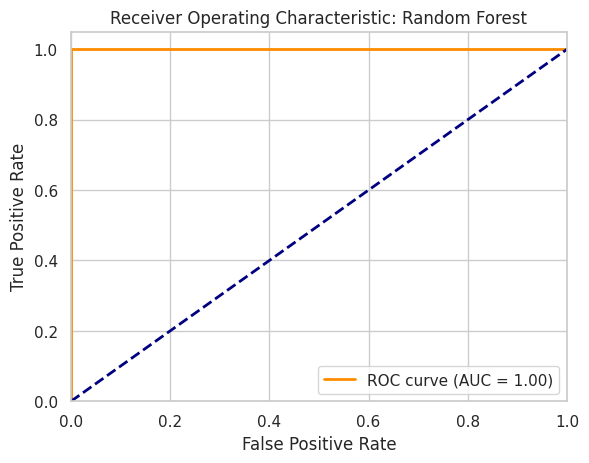

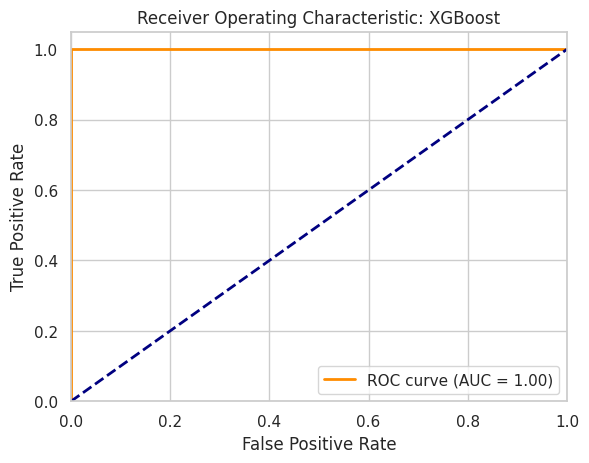

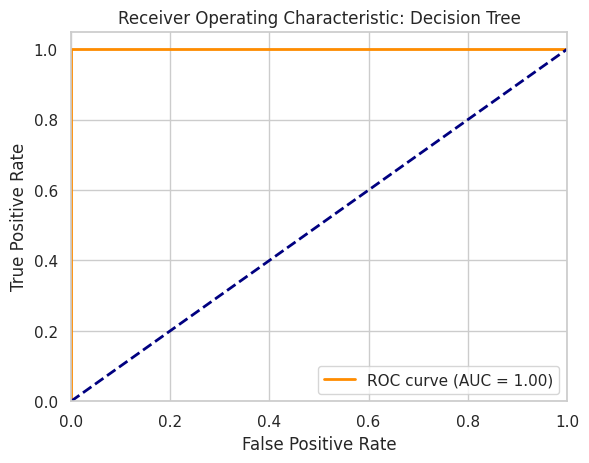

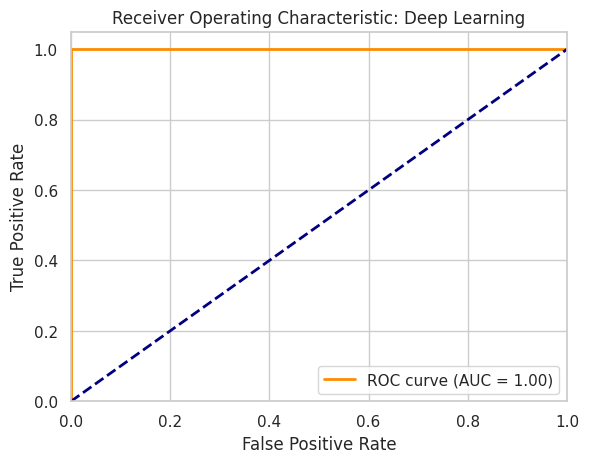

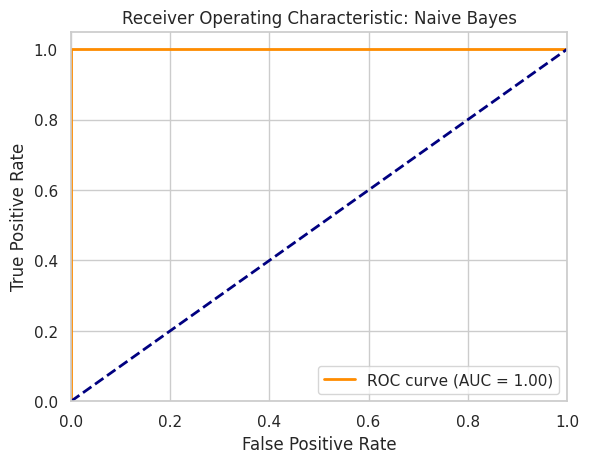

In [49]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import label_binarize

# Function to plot ROC curve and AUC
def plot_roc_curve(y_test, y_probs, model_name):
    fpr, tpr, _ = roc_curve(y_test, y_probs)  # Compute ROC curve
    roc_auc = auc(fpr, tpr)  # Compute AUC

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Random chance line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic: {model_name}')
    plt.legend(loc="lower right")
    plt.show()

# Function to fit models and plot ROC curves with AUC
def fit_and_plot_roc(X_train, X_test, y_train, y_test, models):
    for name, model in models:
        model.fit(X_train, y_train)

        # Predict probabilities or decision function for ROC (binary classification)
        if hasattr(model, "predict_proba"):
            y_probs = model.predict_proba(X_test)[:, 1]  # Probability for class 1
        elif hasattr(model, "decision_function"):
            y_probs = model.decision_function(X_test)
        else:
            raise Exception(f'Model {name} does not have predict_proba or decision_function')

        # Plot ROC curve and AUC
        plot_roc_curve(y_test, y_probs, name)

# Example models (define your models)
# models = [('Logistic Regression', LogisticRegression()), ('Random Forest', RandomForestClassifier())]

# Ensure binary targets for ROC (binarize if necessary)
if len(set(y_train)) > 2:
    y_train = label_binarize(y_train, classes=list(set(y_train)))[:, 0]  # Class 0 vs others
    y_test = label_binarize(y_test, classes=list(set(y_test)))[:, 0]

# Train and plot ROC curve with AUC for multiple models
fit_and_plot_roc(X_train, X_test, y_train, y_test, models)

# For Naive Bayes, get probabilities and plot ROC with AUC
naive_bayes_model = MultinomialNB()
naive_bayes_model.fit(X_train, y_train)
nb_probs = naive_bayes_model.predict_proba(X_test)[:, 1]  # Probability for class 1
plot_roc_curve(y_test, nb_probs, 'Naive Bayes')
